In [1]:
import torchvision
import numpy as np
import TensionFlow as tf
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import torch
import random
import math
import importlib

In [2]:
importlib.reload(tf)

<module 'TensionFlow' from '/media/fakhir/SSD/Experiments/AutoGrad/TensionFlow/TensionFlow.py'>

In [3]:
train_data = torchvision.datasets.MNIST('data/', train=True)
test_data = torchvision.datasets.MNIST('data/', train=False)

In [4]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data/
     Split: Train,
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data/
     Split: Test)

**Forward Pass**

In [5]:
#defining model
f_in = 28*28
f_out = 10

In [6]:
class Model:
    def __init__(self,n_layers,h_dim,f_in,f_out):
        
        self.in_layer = tf.LinearLayer(f_in,h_dim)
        self.out_layer = tf.LinearLayer(h_dim, f_out)
        
        self.layers = []
        for i in range(n_layers):
            self.layers.append(tf.LinearLayer(h_dim,h_dim))
            
    
    def __call__(self, x):
        
#         x = x @ self.in_w + self.in_b.broadcast(x.shape()[0])
        x = self.in_layer.forward(x)
        x = tf.ReLU(x)
        
        for layer in self.layers:
            x = layer.forward(x)
            x = tf.ReLU(x)
        
        x = self.out_layer.forward(x)
        return x

    def update(self, lr):
#         print(self.in_w.grad.sum())
        self.in_layer.update(lr)
        self.out_layer.update(lr)
        
        for layer in self.layers:
            x = layer.update(lr)

In [7]:
lr = 1e-2

In [8]:
lossi = []
test_lossi = []

In [9]:
epochs = 1

In [10]:
batch_size = 64

In [11]:
model = Model(1,50,f_in,f_out)

In [12]:
for e in (range(epochs)):
    t = tqdm(range(0,len(train_data), batch_size))
    for i in t:
        current_batch_size = train_data.data[i:i+batch_size].shape[0]
        inp = train_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
        label = train_data.targets[i:i+batch_size]    

        out_soft = model(tf.Neuron(inp.numpy()))
        oh_label = tf.one_hot(tf.Neuron(label.numpy()), f_out)
        
        loss = tf.CrossEntropy(out_soft.softmax(1),oh_label) 
        loss.backward()

        model.update(lr)
        lossi.append(loss.value[0][0])
        t.set_description(str(loss.value[0][0]))
        loss.backward_zero_grad()
    
    for i in range(0,len(test_data), batch_size):
        current_batch_size = test_data.data[i:i+batch_size].shape[0]
        
        inp = test_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
        label = test_data.targets[i:i+batch_size]    
        
        out_soft = model(tf.Neuron(inp.numpy()))
        oh_label = tf.one_hot(tf.Neuron(label.numpy()), f_out)
        
        loss = tf.CrossEntropy(out_soft.softmax(1),oh_label) 
        
        test_lossi.append(loss.value[0][0])

2.302117514697867: 100%|██████████| 938/938 [01:04<00:00, 14.62it/s] 


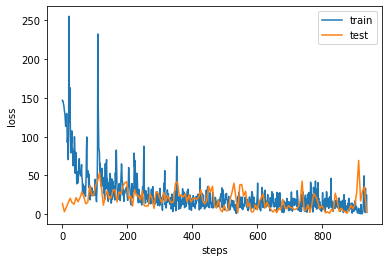

In [13]:
plt.plot(lossi[:])
x = list(range(0,len(lossi), math.ceil(len(lossi)/len(test_lossi))))
plt.plot(x, test_lossi[:len(x)])
plt.xlabel('steps')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show()

In [14]:
batch_size = 16

In [15]:
#accuracy
correct = 0
for i in range(0,len(test_data), batch_size):
    current_batch_size = test_data.data[i:i+batch_size].shape[0]
    inp = test_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
    label = test_data.targets[i:i+batch_size]    
    out_soft = model(tf.Neuron(inp.numpy()))
    correct += (out_soft.argmax(1).value == label.numpy()).sum()
out_soft.make_graph().render('model')

'model.pdf'

In [16]:
correct/ len(test_data)

0.9148

In [17]:
#accuracy
correct = 0
for i in range(0,len(train_data), batch_size):
    current_batch_size = train_data.data[i:i+batch_size].shape[0]
    inp = train_data.data[i:i+batch_size].reshape(current_batch_size,28*28) / 255
    label = train_data.targets[i:i+batch_size]    

    out_soft = model(tf.Neuron(inp.numpy()))
    correct += (out_soft.argmax(1).value == label.numpy()).sum()

In [18]:
correct/ len(train_data)

0.9199333333333334

Pred: 5, label: 5


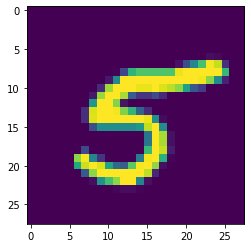

In [105]:
i = random.randint(0,len(test_data))
#inference
inp = test_data.data[i].reshape(1,28*28) / 255
label = test_data.targets[i]    
out_soft = model(tf.Neuron(inp.numpy()))
print(f'Pred: {out_soft.argmax(1).value[0]}, label: {label}')
plt.imshow(test_data.data[i])
